# 8. Деревья решений. (32 балла)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам в Classroom

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиций деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'../../data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
df = pd.read_csv('../Data/winequality-red.csv.gz', sep = ';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


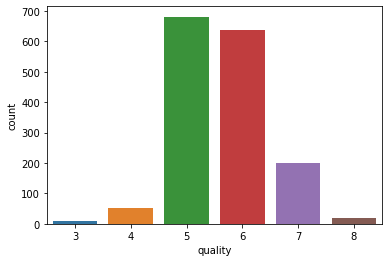

In [2]:
sns.countplot(data=df, x='quality')

В нашем мире хорошее или плохое вино надо ещё пойти поискать.

In [3]:
X = df.drop('quality', axis=1);
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [4]:
y = df['quality']
y

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier 
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов. 

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
kf = KFold(n_splits = 5, random_state = 42, shuffle=True)
res = cross_val_score(KNeighborsClassifier(n_neighbors=10), X, y, scoring='accuracy', cv=kf)
res.mean(), res.std()

(0.5122198275862069, 0.02646141016093271)

In [6]:
from sklearn.preprocessing import StandardScaler
res = cross_val_score(KNeighborsClassifier(n_neighbors=10), StandardScaler().fit_transform(X), y, cv=kf)
res.mean(), res.std()

(0.5797531347962382, 0.014703387246407617)

In [7]:
from sklearn.linear_model import RidgeClassifier
res = cross_val_score(RidgeClassifier(random_state=42), X, y, scoring='accuracy', cv=kf)
res.mean(), res.std()

(0.5835384012539185, 0.03996649901617024)

In [8]:
from sklearn.tree import DecisionTreeClassifier
res = cross_val_score(DecisionTreeClassifier(random_state=42), X, y, scoring='accuracy', cv=kf)
res.mean(), res.std()

(0.6178957680250783, 0.03363095895166169)

In [9]:
from sklearn.ensemble import BaggingClassifier
res = cross_val_score(BaggingClassifier(n_estimators=100, random_state=42), X, y, scoring='accuracy', cv=kf)
res.mean(), res.std()

(0.6954604231974921, 0.032421733218408647)

In [10]:
from sklearn.ensemble import BaggingClassifier
res = cross_val_score(BaggingClassifier(n_estimators=100, max_features=0.5, random_state=42), X, y, scoring='accuracy', cv=kf)
res.mean(), res.std()

(0.6992123824451411, 0.022534053776467534)

In [11]:
from sklearn.ensemble import RandomForestClassifier
res = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X, y, scoring='accuracy', cv=kf)
res.mean(), res.std()

(0.7017143416927899, 0.02872158354161314)

### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без
- почему масштабирование не важно для деревьев решений
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??

1)Без масштабирования признаки с большим диапазоном значений оказываются приоритетными, а это не всегда правильно

2)Потому что в дерево решений смотрит на каждый признак в отдельности, не сравнивая его с другими. 
Алгоритмы, основанные на метриках, так не могут.

3)Доступ только к половине признаков делает модель менее зависимой от конкретного датасета, на которой она тренинуется

4)У линейной, потому что всё линейное не очень :D

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятся делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

In [13]:
from sklearn import datasets

X, y = datasets.load_digits(return_X_y=True)
X.shape[1]

64

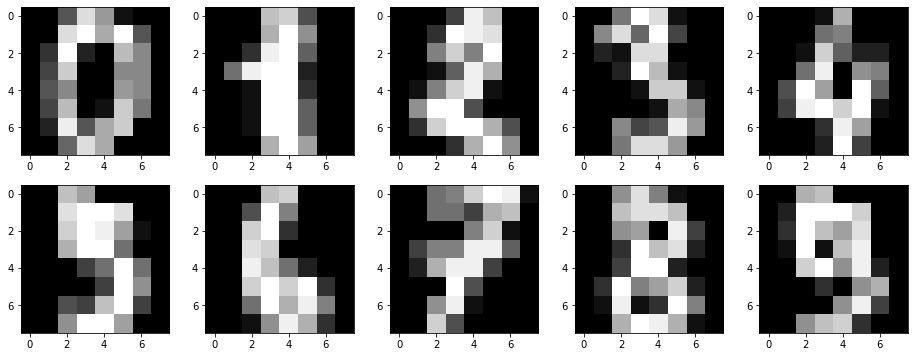

In [14]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray')

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [15]:
kf = KFold(n_splits = 10, random_state = 42, shuffle=True)
res = cross_val_score(DecisionTreeClassifier(random_state=42), X, y, scoring='accuracy', cv=kf)
res.mean(), res.std()

(0.8525294847920547, 0.01599405007513365)

In [16]:
res = cross_val_score(BaggingClassifier(n_estimators=100, random_state=42), X, y, scoring='accuracy', cv=kf)
res.mean(), res.std()

(0.9488019863438858, 0.01664715013813904)

In [17]:
max_feat = np.sqrt(X.shape[1])/X.shape[1]
res = cross_val_score(BaggingClassifier(n_estimators=100, max_features=max_feat, random_state=42), X, y, scoring='accuracy', cv=kf)
res.mean(), res.std()

(0.9571725636250775, 0.015687049408620417)

In [18]:
d_tree = DecisionTreeClassifier(random_state=37, max_features=max_feat)
res = cross_val_score(BaggingClassifier(base_estimator=d_tree,n_estimators=100, random_state=42), X, y, scoring='accuracy', cv=kf)
res.mean(), res.std()

(0.9766263190564866, 0.006485517380378529)

In [19]:
res = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X, y, scoring='accuracy', cv=kf)
res.mean(), res.std()

(0.9794196151458723, 0.010835182102050938)

### 2.3 В чём разница? (3 балла)

Ответье на вопрос: 

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?

![](https://i.ytimg.com/vi/_5GWMIAHc08/hqdefault.jpg)

Если ограниченый набор признаков един для всех деревьев, то хоть это и уменьшает возможность деревьев "привязаться"
к конкретным данным, но в то же время количество полезной информации, с которой работает алгоритм, уменьшается, деревья получаются
менее точными.

Если же выделять признаки индивидуально для каждого дерева, то это повышает вероятность получить адекватный предсказатель
так как полезная информация в результате не теряется.

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

In [20]:
tree_numbers = [1,5,10,15,50,100,150,200,300]
results = []
for n in tree_numbers:
    results.append(cross_val_score(RandomForestClassifier(n_estimators=n, random_state=42), X, y, scoring='accuracy', cv=kf).mean())
results

[0.790707635009311,
 0.9153941651148354,
 0.9488019863438858,
 0.9577001862197392,
 0.9760800744878957,
 0.9794196151458723,
 0.9805307262569833,
 0.9783054003724395,
 0.9771880819366853]

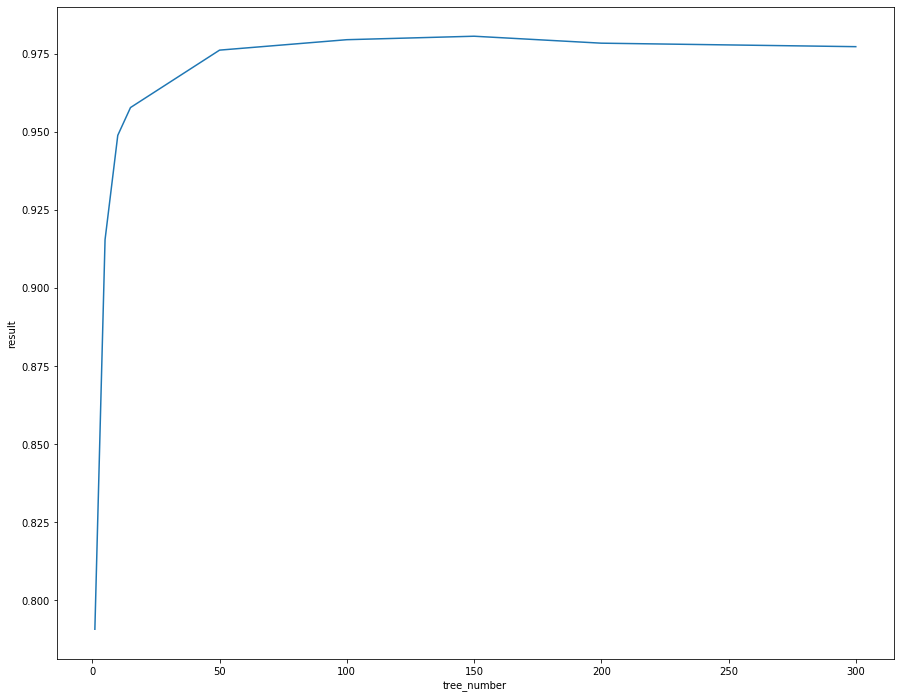

In [21]:
plt.figure(figsize=(15, 12))
plt.plot(tree_numbers, results)
plt.xlabel("tree_number")
plt.ylabel("result")
plt.show()

### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

In [25]:
feature_numbers = np.arange(1, 65, 5)
results = []
for n in feature_numbers:
    results.append(cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42, max_features=n), X, y, scoring='accuracy', cv=kf).mean())
results

[0.9738516449410305,
 0.9760738671632525,
 0.9782991930477964,
 0.9716108007448788,
 0.9760707635009311,
 0.9716139044072005,
 0.9693885785226566,
 0.9654996896337679,
 0.9643823711980136,
 0.9632619490999378,
 0.9571477343265051,
 0.9538144009931718,
 0.9526939788950962]

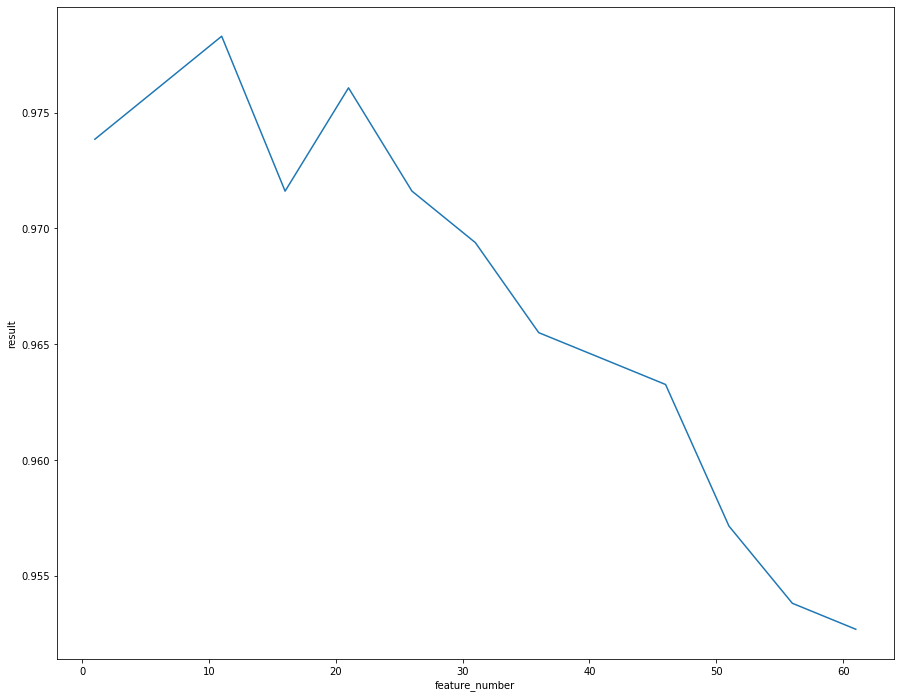

In [26]:
plt.figure(figsize=(15, 12))
plt.plot(feature_numbers, results)
plt.xlabel("feature_number")
plt.ylabel("result")
plt.show()

### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?

1) Сначала качество растёт, но затем начинает колебаться примерно на одном уровне. Брать 5000 деревьев, в принципе, можно, но смысла в этом мало - производительность падает, а качество не улучшается.

2) Слишком большое число фич "привязывает" предсказатель к конкретным данным, а слишком маленькое - не даёт достаточно информации. Нужна золотая середина.

3) См 2.

4) Глубокое дерево значит либо неэффективность классификации, либо привязку к конкретным данным. И то и это плохо(

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)